# User facing explanations in the context of adverse action notices

Shapley values are widely used by model developers to quantify the importance of features while debugging or exploring patterns in data. They can also be used to produce user-facing explanations of model predictions. When producing explanations that are given to end-users it is critically important to consider the goals of the explanation, and how Shapley values meet (or fail to meet) these goals. These goals are specific to the context and the users, so the evaluation of how best to use Shapley values (or any other approach) must be done in context. This article provides an example of how to do that in the context of finanical adverse action notices, which are short, legally required, explanations provided to consumers when they are declined for a loan or some other financial product. This notebook was developed as part of a U.S. CFPB sponsored hackathon, and so focuses specifically on the notices as required by U.S. transparecy laws such as the ECOA and Reg B, and how Shapley values can be applied in this setting. Note that this notebook is not legal advice or a careful exposition of regulatory requirments and standard practice, and is strictly illustrative in nature.


## Define your goals

The first step when building user-facing explanations is to identify the goals of the explanation. In order words, why is this explanation provided to the user, and what is the purpose we want the explanation to satisfy? For adverse action notices in the U.S. we can directly use the three regulatory goals as stated by the CFPB: 

- Notifying consumers about potential inaccuracies in the information used to take adverse action.
- Preventing and helping reveal discrimination on a prohibited basis.
- Educating consumers about how they might improve their chances of being approved for credit in the future.


## Determine how explanations map to those goals

To determine how adverse action explanations based on Shapley values accomplish (or fail to accomplish) the above goals, it is helpful to start by considering previous standard practice.  Adverse action notices have been around for decades, and have traditionally been reported using a simple measure of importance for linear models.

presents several proposals designed to improve the quality of the adverse action notices delivered to consumers.


It is important however to carefully consider the 


enable a measure of transparency for users. but it is important to keep in mind the different goals of these use cases.  This notebook was developed as part of a U.S. CFPB sponsored hackathon, and presents several proposals designed to improve the quality of the adverse action notices delivered to consumers. As such it serves as an example of how Shapley values might be applied in a financial setting. Note that this notebook is not legal advice, and is strictly illustrative in nature. It is also forward-looking, since it considers not how to recreate the current state of the art, but how to improve on it. The notebook focuses specifically on the notices as required by U.S. transparecy laws such as the ECOA and Reg B, and how Shapley values can be applied in this setting.

**Regulatory goals for adverse action notices:** *(as stated by the CFPB)*
- Notifying consumers about potential inaccuracies in the information used to take adverse action.
- Preventing and helping reveal discrimination on a prohibited basis.
- Educating consumers about how they might improve their chances of being approved for credit in the future.


There are two subtle, yet important, issues with current adverse action notices: 1) It is easy and common to provide incomplete explanations, and 2) *the most important reasons why a person was denied aren't nessecarily the most actionable*. In this notebook we demonstrate how to address both these problems when using Shapley values for explainability. For (1) we show how explaining the entire end-to-end decisioning process avoid providing users with incomplete explanations. For (2) we show how separating reason codes from what we call "action codes" we can avoid conflating importance with actionability.

To examine each of these problems and demonstrate our proposed solutions we set up a representative loan decision making process based on the publically available FICO challenge HELOC data set which can be obtained at community.fico.com/s/xml. We start by loading the data and defining a scoring process, then we use the data and scoring process to demonstrate the problems outlined above and the corresponding solutions.

## Load the FICO challenge HELOC data

In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
import matplotlib.pyplot as pl
import scipy as sp
import copy

data = pd.read_csv('../../../cfpb_tech_sprint/data/heloc_dataset_v1.csv')
data['RiskPerformance'] = np.where(data['RiskPerformance'] == "Bad", 0, 1)
data["NoBureauRecord"] = (data["NumInqLast6M"] == -9) * 1
data_local = data.drop(["ExternalRiskEstimate"], axis=1)

y = data["RiskPerformance"] 
X = data.drop(["RiskPerformance"], axis=1)
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X, y, train_size=0.6, random_state=0)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid, y_valid, train_size=0.5, random_state=0)

## Setup an illustrative loan descision making process

This section trains a set of models that are meant to reflect the typical scoring process that occurs for loan application descisions. It consists of an ensemble of a XGBoost model, a feed-forward neural network model, an external credit score factor, and a set of manual policy exclusions. Each of these models are defined and trained below (as well as a linear model used for comparison).

### Train a WOE linear model

The WOE linear model is not used the final ensemble, but is included here for performance comparison.

In [2]:
# define the gini index
def gini(y, yhat):
    return 2 * sklearn.metrics.roc_auc_score(y, yhat) - 1

from sklearn.linear_model import LogisticRegression

woe_drop_features = ["ExternalRiskEstimate", "NoBureauRecord"]
binner = sklearn.preprocessing.KBinsDiscretizer(n_bins=10, encode="ordinal")
binner.fit(X_train.drop(woe_drop_features, axis=1))
from category_encoders import WOEEncoder
woe_encoder = WOEEncoder(
    cols=list(range(X_train.shape[1] - len(woe_drop_features))),
    regularization=1e-8
)
woe_encoder.fit(binner.transform(X_train.drop(woe_drop_features, axis=1)), y_train)

def woe_preprocess(X):
    X_new = X.copy()
    X_new = X_new.drop(woe_drop_features, axis=1)
    return woe_encoder.transform(binner.transform(X_new))

woe_model = LogisticRegression(max_iter=10000)
woe_model.fit(woe_preprocess(X_train), y_train)

yhat = woe_model.predict_proba(woe_preprocess(X_test))[:,1]
print("ROC AUC", sklearn.metrics.roc_auc_score(y_test, yhat))
print("Gini index", gini(y_test, yhat))

Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 6 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 9 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 11 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 13 are removed. Consider decreasing the number of bins.
Bins whose width are too small (i.e., <= 1e-8) in feature 14 are removed. Consider decreasing 

X       0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
0      1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
1      2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
2      3   3   3   3   3   3   3   3   2   3  ...   3   3   1   1   1   3   3   
3      4   4   1   4   1   1   1   1   1   1  ...   3   1   1   1   3   4   3   
4      5   2   2   5   1   1   3   4   1   1  ...   2   4   3   3   4   5   1   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
6270   8   1   1  10   1   1   3   3   4   1  ...  10   4   3   3   3   7   9   
6271   9   6   8   1   1   1   5   5   3   1  ...   4   4   3   3   9   5   7   
6272   2   2   2   2   2   2   2   2   2   2  ...   2   2   2   2   2   2   2   
6273   9   4   8   7   4   3   6   1   4   3  ...   5   4   4   4   3   8   9   
6274   5   3   3  10   1   1   6   1   1   1  ...   9   6   3   3   7   5   7   

      19  20  21  
0     

### Train an XGBoost model

In [3]:
def xgb_preprocess(X):
    X_new = X.copy()
    X_new = X_new.drop(["ExternalRiskEstimate", "NoBureauRecord"], axis=1)
    return X_new

xgb_model = xgboost.XGBClassifier(
    max_depth=3, subsample=0.5, colsample_bytree=0.5,
    learning_rate=0.001, n_estimators=30000
)
xgb_model.fit(
    xgb_preprocess(X_train), y_train,
    eval_set=[(xgb_preprocess(X_valid), y_valid)],
    early_stopping_rounds=2000,
    eval_metric=lambda predt, dtrain: ('NegativeGini', -gini(dtrain.get_label(), predt)),
    verbose=2000
)
yhat = xgb_model.predict(xgb_preprocess(X_test), output_margin=True)
print("ROC AUC", sklearn.metrics.roc_auc_score(y_test, yhat))
print("Gini index", gini(y_test, yhat))

[16:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.69304	validation_0-NegativeGini:-0.33121


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[2000]	validation_0-logloss:0.57642	validation_0-NegativeGini:-0.57005
[4000]	validation_0-logloss:0.55914	validation_0-NegativeGini:-0.57788
[6000]	validation_0-logloss:0.55568	validation_0-NegativeGini:-0.57880
[7432]	validation_0-logloss:0.55547	validation_0-NegativeGini:-0.57862
ROC AUC 0.8018167546372543
Gini index 0.6036335092745087


### Train a simple feed forward neural network

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

fnn_drop_features = [
        "ExternalRiskEstimate", "NoBureauRecord", "MSinceOldestTradeOpen",
        "NumRevolvingTradesWBalance", "NumTrades90Ever2DerogPubRec", "PercentTradesNeverDelq"
]
scaler = preprocessing.StandardScaler().fit(X_train.drop(fnn_drop_features, axis=1))
def fnn_preprocess(X):
    X_new = X.copy()
    X_new = X_new.drop(fnn_drop_features, axis=1)
    return scaler.transform(X_new)

fnn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 8, 2), random_state=1, max_iter=10000)
fnn_model.fit(fnn_preprocess(X_train), y_train)
yhat = fnn_model.predict_proba(fnn_preprocess(X_test))[:,1]
print("ROC AUC", sklearn.metrics.roc_auc_score(y_test, yhat))
print("Gini index", gini(y_test, yhat))

ROC AUC 0.7415021879550598
Gini index 0.4830043759101197


### Train an XGBoost model to calibrate the external data feed

In [5]:
def external_preprocess(X):
    return X[["ExternalRiskEstimate"]]

external_model = xgboost.XGBClassifier(
    max_depth=1, subsample=0.5, colsample_bytree=0.5,
    learning_rate=0.01, n_estimators=30000
)
external_model.fit(
    external_preprocess(X_train), y_train,
    eval_set=[(external_preprocess(X_valid), y_valid)],
    early_stopping_rounds=200,
    eval_metric=lambda predt, dtrain: ('NegativeGini', -gini(dtrain.get_label(), predt)),
    verbose=100
)
yhat = external_model.predict(external_preprocess(X_test), output_margin=True)
print("ROC AUC", sklearn.metrics.roc_auc_score(y_test, yhat))
print("Gini index", gini(y_test, yhat))

[16:09:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.69162	validation_0-NegativeGini:-0.38056


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[100]	validation_0-logloss:0.61956	validation_0-NegativeGini:-0.46522
[200]	validation_0-logloss:0.60416	validation_0-NegativeGini:-0.48396
[300]	validation_0-logloss:0.59920	validation_0-NegativeGini:-0.49317
[400]	validation_0-logloss:0.59640	validation_0-NegativeGini:-0.49273
[500]	validation_0-logloss:0.59500	validation_0-NegativeGini:-0.49389
[600]	validation_0-logloss:0.59440	validation_0-NegativeGini:-0.49435
[700]	validation_0-logloss:0.59429	validation_0-NegativeGini:-0.49519
[800]	validation_0-logloss:0.59437	validation_0-NegativeGini:-0.49482
[873]	validation_0-logloss:0.59447	validation_0-NegativeGini:-0.49495
ROC AUC 0.763908094883523
Gini index 0.5278161897670459


### Define the full end-to-end approval system

In [6]:
def approval_score(X):
    """ This returns the overall approval score, which is on a probability scale right now.
    """
    approve = np.ones(X.shape[0])
    
    # policy exclusions
    approve[X["NoBureauRecord"] == 1] = 0
    approve[X["NumInqLast6M"] >= 10] = 0
    approve[X["MaxDelq2PublicRecLast12M"] == 0] = 0
    
    # XGBoost model cutoff
    xgb_prob = xgb_model.predict_proba(xgb_preprocess(X))
    
    # FNN model cutoff
    fnn_prob = fnn_model.predict_proba(fnn_preprocess(X))
    
    # external estimate cutoff
    external_prob = external_model.predict_proba(external_preprocess(X))
    
    out = approve * (xgb_prob + fnn_prob + external_prob)[:,1]/3
    
    return out

rank_model = xgboost.XGBRegressor()
yhat_train = approval_score(X_train)
rank_model.fit(yhat_train.reshape(-1, 1), 100 * np.argsort(np.argsort(yhat_train))/len(yhat_train))
def approval_score_percentile(X):
    return rank_model.predict(approval_score(X).reshape(-1,1))

approval_score(X_test).mean()

0.44680933159256014

## Explain the full end-to-end approval system

To explain the whole pipeline we just use the default model-agnostic SHAP explainer (which is shap.explainer.Permutation).

In [7]:
# choose 100 people near our decison cutoff as the background we compare against
# (you can choose just 10 people to speed things up)
bg = X_train.iloc[np.argsort(np.abs(approval_score(X_train) - 0.5))[:100]]

# explain the percentile score function
explainer = shap.Explainer(approval_score_percentile, bg)
mary_index = 140
john_index = 455
shap_values = explainer(X_test.iloc[[mary_index,john_index]])

## Problem #1: Incomplete explanations (based on the "Mary" persona)

In [8]:
# group and rename the features
name_map = {
    "MSinceOldestTradeOpen": "Length of time oldest account has been established",
    "MSinceMostRecentTradeOpen": "Length of time newest account has been established",
    "AverageMInFile": "Length of time credit report has been established",
    "NumSatisfactoryTrades": "Lower number of non-delinquent accounts",
    "NumTrades60Ever2DerogPubRec": "Delinquency in credit report",
    "NumTrades90Ever2DerogPubRec": "Delinquency in credit report",
    "PercentTradesNeverDelq": "Number of delinquent accounts in past",
    "MSinceMostRecentDelq": "Length of time since recent delinquency in credit report",
    "MaxDelq2PublicRecLast12M": "Delinquency in last 12 months in credit report",
    "MaxDelqEver": "Delinquency in credit report",
    "NumTotalTrades": "Number of credit accounts",
    "NumTradesOpeninLast12M": "Too many recently opened accounts",
    "PercentInstallTrades": "Number of installment accounts",
    "MSinceMostRecentInqexcl7days": "Recency of credit inquiry",
    "NumInqLast6M": "Too many credit inquiries in last 6 months",
    "NumInqLast6Mexcl7days": "Too many credit inquiries in last 6 months",
    "NetFractionRevolvingBurden": "High revolving debt",
    "NetFractionInstallBurden": "High installment debt",
    "NumRevolvingTradesWBalance": "Number of Revolving accounts with Balance",
    "NumInstallTradesWBalance": "Number of Installment accounts with Balance",
    "Number of Installment accounts with Balance": "Number of accounts with high utilization",
    "PercentTradesWBalance": "Number of accounts with balance",
    "NoBureauRecord": "No credit bureau data available"
}
shap_values_grouped = shap_values.sum(axis=1, grouping=name_map)

def shap_reason_codes(shap_row):
    shap_row_grouped = shap_row.sum(grouping=name_map)
    order = np.argsort(shap_row_grouped.values)
    return [shap_row_grouped.feature_names[i] for i in order[0:3] if shap_row_grouped.values[i] < -2]

def standard_reason_codes(shap_row):
    
    # policy exclusions
    if shap_row["NoBureauRecord"].data == 1:
        return [name_map["NoBureauRecord"]]
    elif shap_row["NumInqLast6M"].data >= 10:
        return [name_map["NumInqLast6M"]]
    elif shap_row["MaxDelq2PublicRecLast12M"].data == 0:
        return [name_map["MaxDelq2PublicRecLast12M"]]
    
    # here we use the end-to-end SHAP values for convienence, but in reality a much simpler
    # method might be used after the policy exclusions
    return shap_reason_codes(shap_row)

def is_accepted(shap_row):
    return shap_row.base_values + shap_row.values.sum() > 56.97762299

### Standard reason codes
When we run the standard reason code generation process we see that Mary is declined with a single reason code:

In [9]:
is_accepted(shap_values[0])

False

In [10]:
standard_reason_codes(shap_values[0])

['Too many credit inquiries in last 6 months']

Now imagine Mary waits 4 months to lower her number of recent credit inquiries. It turns out should just gets denied again! This time for another reason.

In [11]:
new_mary = copy.copy(X_test[mary_index:mary_index+1])
new_mary["NumInqLast6M"] = 4
new_mary["NumInqLast6Mexcl7days"] = 4
approval_score_percentile(new_mary)
new_mary_shap_values = explainer(new_mary)[0]

In [12]:
is_accepted(new_mary_shap_values)

False

In [13]:
standard_reason_codes(new_mary_shap_values)

['High revolving debt',
 'ExternalRiskEstimate',
 'Too many credit inquiries in last 6 months']

In [14]:
standard_reason_codes(new_mary_shap_values)

['High revolving debt',
 'ExternalRiskEstimate',
 'Too many credit inquiries in last 6 months']

### Reason codes based on a full process explanation 

Why did Mary get denied again after she addressed the reason code she was given? It is because we only told Mary a part of the story, there are actually several things preventing her from getting a loan, and having way too many credit inquiries was just the first thing we checked (as a policy exclusion). A better explanation would be based on a credit allocation process applied to the whole decision system. When we use SHAP to do this we get a full set of reason codes that include both the policy cutoff failure and issues from the ML models:

In [15]:
shap_reason_codes(shap_values[0])

['Too many credit inquiries in last 6 months',
 'ExternalRiskEstimate',
 'High revolving debt']

If Mary now addresses all of these factors she gets accepted:

In [16]:
new_mary2 = copy.copy(X_test[mary_index:mary_index+1])
new_mary2["NumInqLast6M"] = 4
new_mary2["NumInqLast6Mexcl7days"] = 4
new_mary2["NetFractionRevolvingBurden"] = 30
new_mary2["ExternalRiskEstimate"] = 70
new_mary_shap_values2 = explainer(new_mary2)[0]
is_accepted(new_mary_shap_values2)

False

In [20]:
new_mary_shap_values2.shape

(24,)

To see what what really happening with Mary we can visualize the full process explanation and see that while the policy cutoff does indeed make a high impact, it is not the only factor negatively effecting Mary's application:

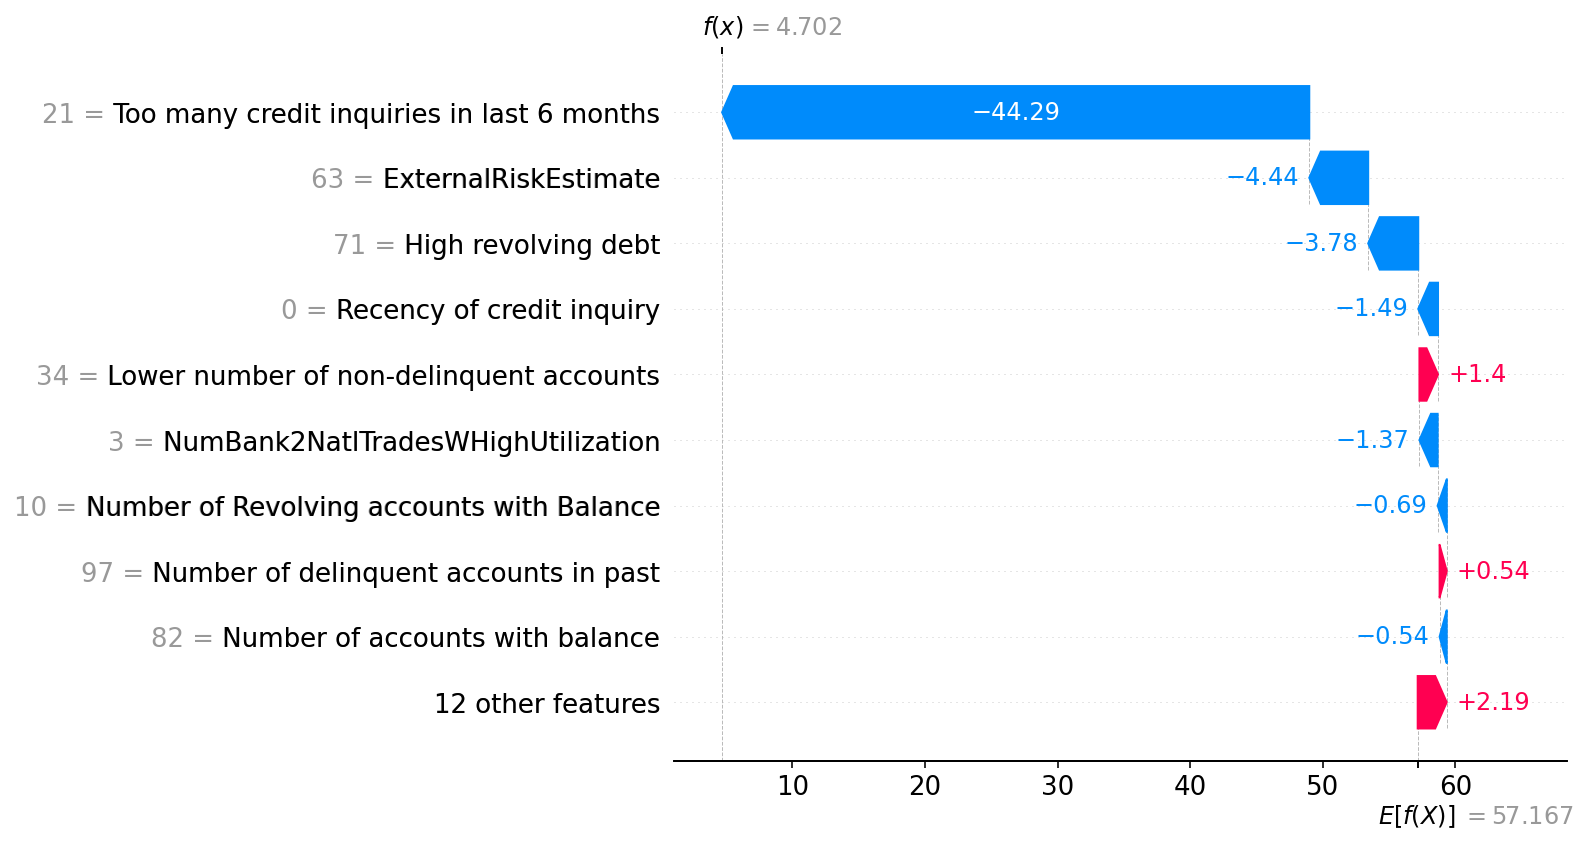

In [77]:
shap.plots.waterfall(shap_values[0].sum(grouping=name_map))

## Problem #2: Good reason codes are not nessecarily good "action codes" (based on the "John" persona)

For Mary, just giving her more reason codes was enough to help her figure out how to get accepted. But for John his reason codes are not very actionable since they have to do with the length of his credit history: 

In [78]:
john = copy.copy(X_test[john_index:john_index+1])
john_shap_values = explainer(john)[0]
is_accepted(john_shap_values)

False

In [79]:
shap_reason_codes(john_shap_values)

['Length of time credit report has been established',
 'Recency of credit inquiry']

### Generating action codes

While the reason codes for John are correct, the top one is not very actionable since it just says he has too short a credit history. If John looks at this he might think that he just needs to wait longer to get a better score, but it turns out that while his short credit history is the biggest factor in the decision, there are easier actions he can take other than waiting. To find them we define a set of possible actions (and the costs associated with taking those actions) and then find the cheapest set of actions that will get John accepted:

In [80]:
class ImproveExternalScore(shap.actions.Action):
    def __init__(self, amount):
        self.amount = amount
        self.cost = 5 * amount
        self.name = f"Improve credit score by {amount} points"
    
    def __call__(self, X):
        X["ExternalRiskEstimate"] += self.amount
        
    def __str__(self):
        return f"Improve credit score by {self.amount} points"
    
class WaitSixMonthsWithNoInquiry(shap.actions.Action):
    def __init__(self):
        self.cost = 10
        self.name = "Wait six months without a credit inquiry"
    
    def __call__(self, X):
        X["MSinceOldestTradeOpen"] += 6
        X["MSinceMostRecentTradeOpen"] += 6
        X["AverageMInFile"] += 6
        X["MSinceMostRecentDelq"] += 6
        X["NumInqLast6M"] = 0
        X["NumInqLast6Mexcl7days"] = 0
        
    def __str__(self):
        return "Wait six months without a credit inquiry"
    
class ReduceRevolvingDebt(shap.actions.Action):
    def __init__(self, amount):
        self.amount = amount
        self.cost = amount / 2
        self.name = f"Reduce revolving debt by {amount}%"
    
    def __call__(self, X):
        X["NetFractionRevolvingBurden"] = np.max(X["NetFractionRevolvingBurden"] - self.amount, 0)
        
    def __str__(self):
        return f"Reduce revolving debt by {self.amount}%"



In [81]:
def model_clearly_passed(x):
    s = approval_score_percentile(x.to_frame().T)[0]
    return s > 57

possible_actions = [
    [ImproveExternalScore(i) for i in range(1,10)],
    WaitSixMonthsWithNoInquiry(),
    [ReduceRevolvingDebt(i) for i in range(1,20)]
]
optimizer = shap.ActionOptimizer(model_clearly_passed, possible_actions)
actions = optimizer(X_test.iloc[john_index])
actions

Note that ActionOptimizer is still in an alpha state and is subjust to API changes.


[<Action 'Reduce revolving debt by 15%'>,
 <Action 'Improve credit score by 2 points'>]

By optimizing for the best action we can return "action codes" that directly answer the question: "What can I do do improve my credit score?". This is of course a different question than "What is the most important factor getting me declined?" Both questions are useful in the context of adverse action notices, the latter is userful for the first two regulatory goals mentioned above of preventing discrimination and catching impactful credit file errors, while the former is useful for the third regulatory goal of helping people know what is the best action to take. Shapley values (like standard ANN methods) are a great choice for feature importance, but they are a terrible choice for answering "best action" questions. Which is why we think it is very important to separate these goals and target "action codes" and "reason codes" separately with separate algorithms (as demonstrated here).

Here we can see how action codes help John get accepted:

In [83]:
john = copy.copy(X_test[john_index:john_index+1])
john["NetFractionRevolvingBurden"] -= 15
john["ExternalRiskEstimate"] += 2
john_shap_values = explainer(john)[0]
is_accepted(john_shap_values)

True

## Problem #4: No quantitative information

This notebook does not really demo our solution to problem 4, see the presentation for mockups and demos. Instead we just show how quantitative information is available from our reason codes (and is also available for action codes).

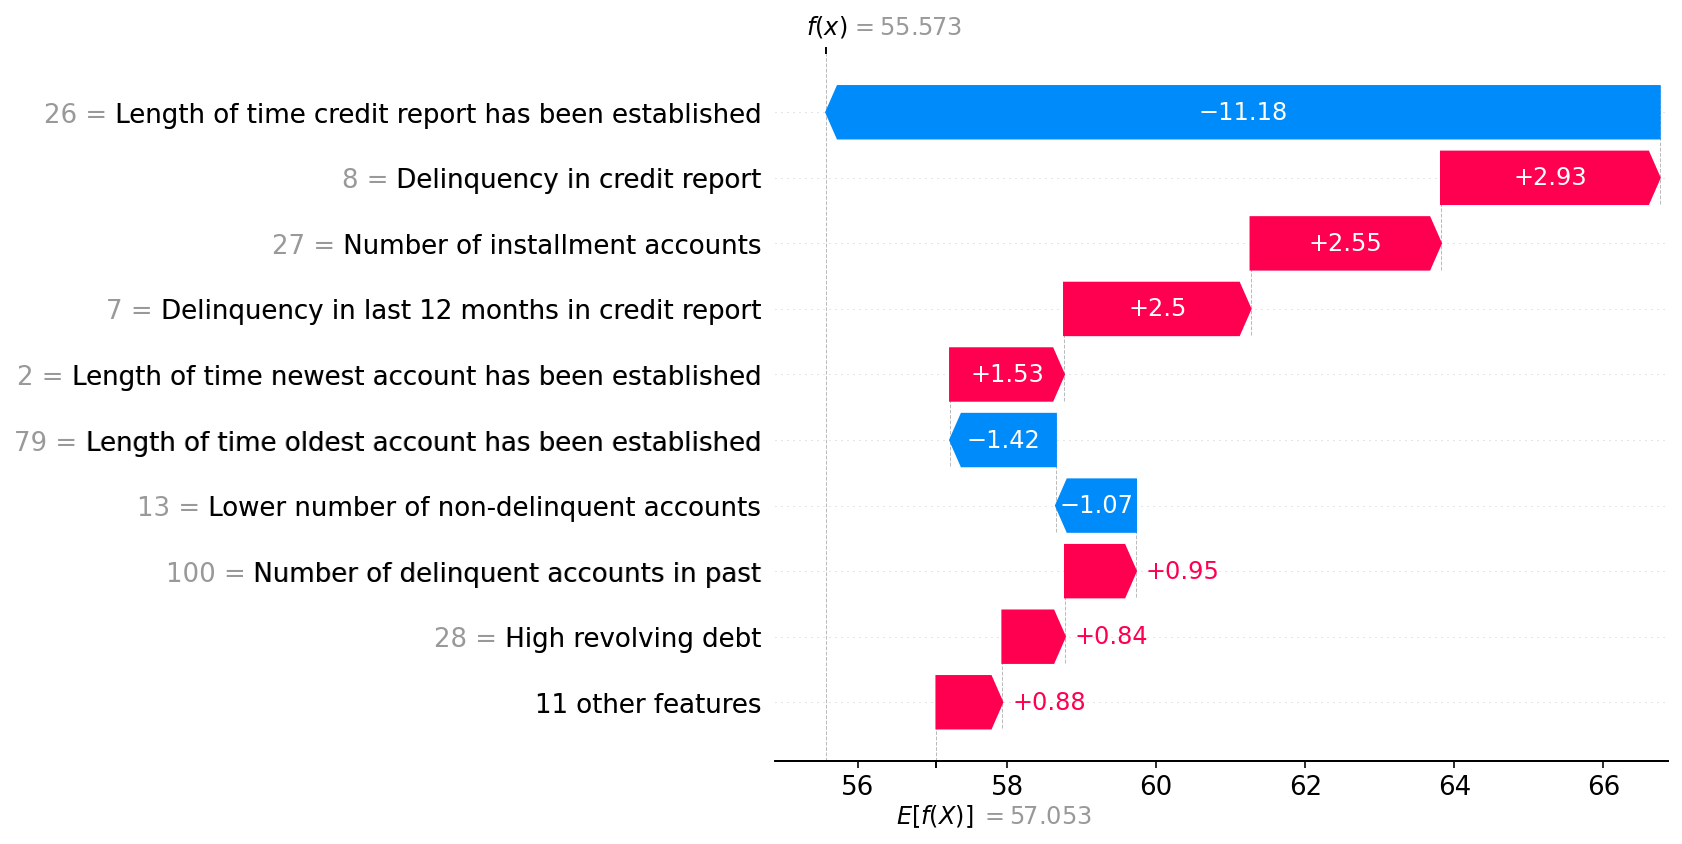

In [41]:
# John's quantitate values that we can use to communicate how length of credit report
# is by far the most important factor
shap.plots.waterfall(john_shap_values.sum(grouping=name_map))

In [72]:
john2 = copy.copy(X_test[john_index:john_index+1])
john2["NetFractionRevolvingBurden"] -= 15
john2["ExternalRiskEstimate"] += 2
john2_shap_values = explainer(john2)[0]
is_accepted(john2_shap_values)

True

In [75]:
john = copy.copy(X_test[john_index:john_index+1])
john_shap_values = explainer(john)[0]
is_accepted(john_shap_values)

False

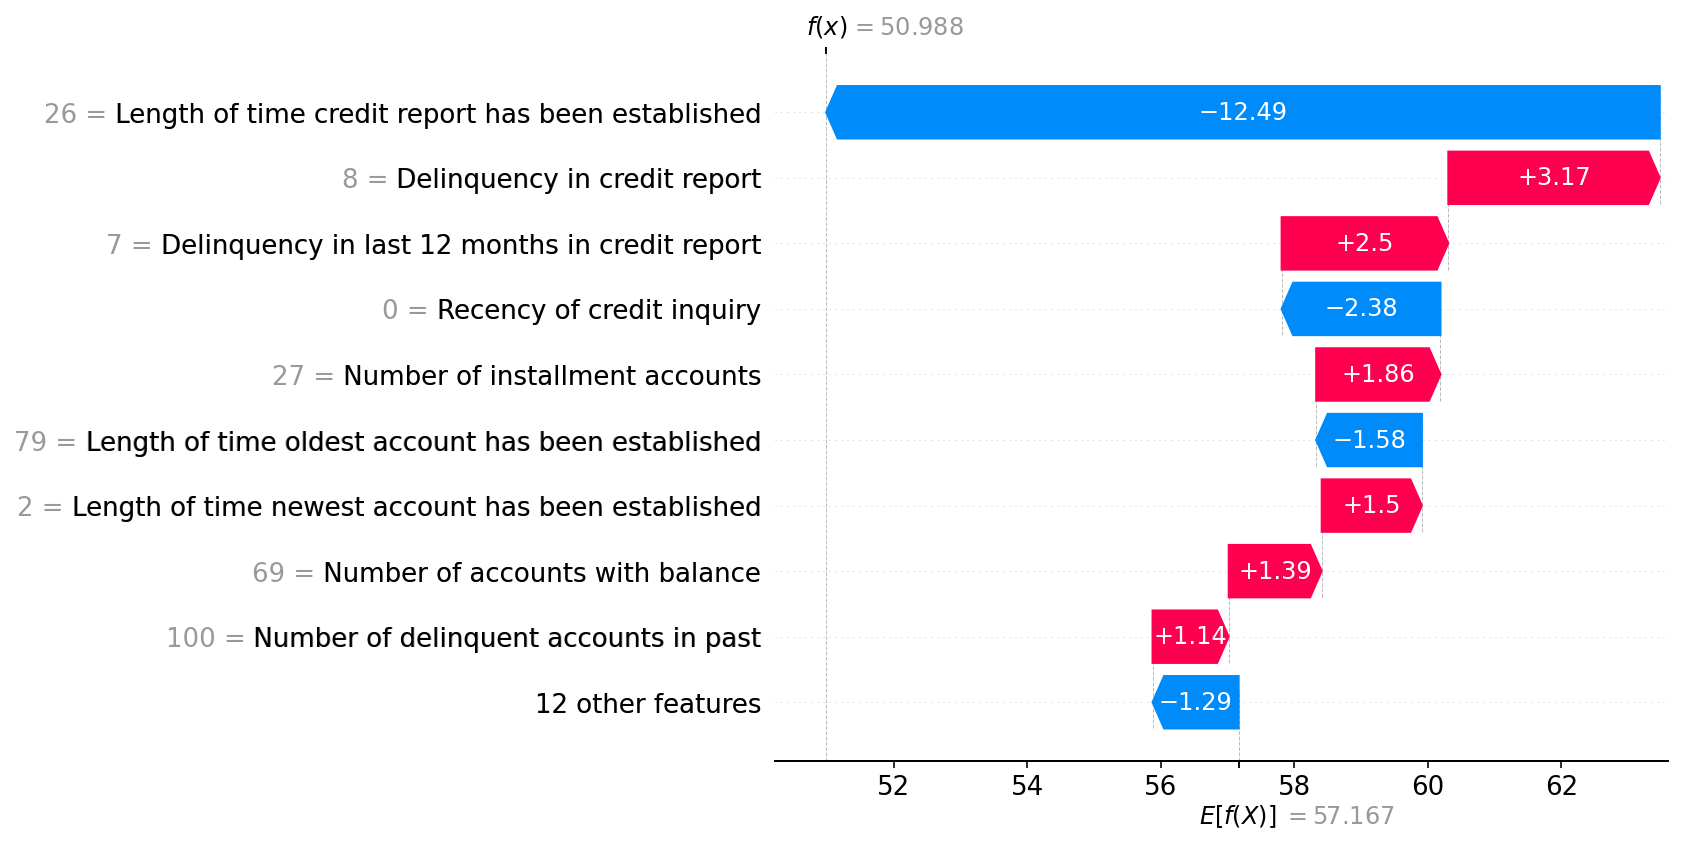

In [76]:
shap.plots.waterfall(john_shap_values.sum(grouping=name_map))

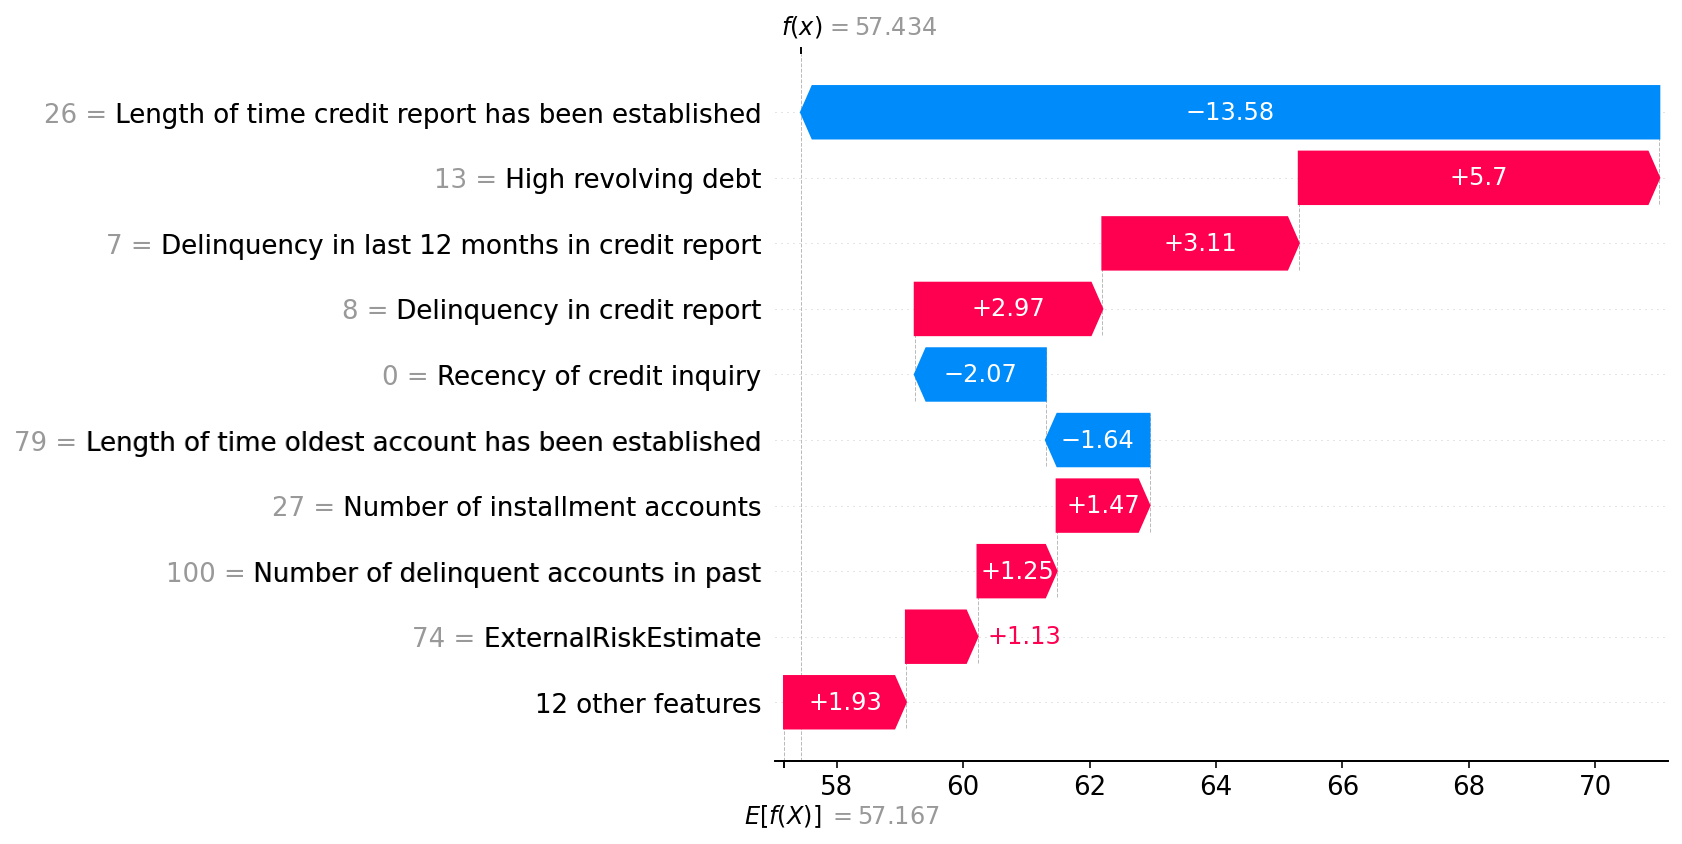

In [74]:
shap.plots.waterfall(john2_shap_values.sum(grouping=name_map))